## Load libraries

In [1]:
# tensorflow backend
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
import sys
sys.path.append('../')

from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu
# import scientific py
import numpy as np
import pandas as pd
# rdkit stuff
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


# Load a model

In [4]:
vae = VAEUtils(directory='chemical_vae/models/zinc_properties')

From /home/fabsta/.conda/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1210: calling reduce_prod (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
/home/fabsta/.conda/envs/chemvae/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
From /home/fabsta/.conda/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1192: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
From /home/fabsta/.conda/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1156: calling reduce_max

Using standarized functions? True
Standarization: estimating mu and std values ...done!


# Using the VAE


## Decode/Encode 

Might not be perfect (it's probabilistic), try it several times.

smiles <i class="fa fa-arrow-right" aria-hidden="true"></i> x <i class="fa fa-arrow-right" aria-hidden="true"></i> z <i class="fa fa-arrow-right" aria-hidden="true"></i> x_r <i class="fa fa-arrow-right" aria-hidden="true"></i> smiles_r

In [26]:
smiles_1 = mu.canon_smiles('CSCC(=O)NNC(=O)c1c(C)oc(C)c1C')

X_1 = vae.smiles_to_hot(smiles_1,canonize_smiles=True)
z_1 = vae.encode(X_1)
X_r= vae.decode(z_1)

print('{:20s} : {}'.format('Input',smiles_1))
print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r,strip=True)[0]))

print('{:20s} : {} with norm {:.3f}'.format('Z representation',z_1.shape, np.linalg.norm(z_1)))

Input                : CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
Reconstruction       : CSCC(=O)N)C(=O)c1c(C)oc(C)c1C
Z representation     : (1, 196) with norm 10.674


In [11]:
aspirin = mu.canon_smiles('CC(=O)OC1=CC=CC=C1C(=O)O')
X_1 = vae.smiles_to_hot(aspirin, canonize_smiles=True)
z_1 = vae.encode(X_1)
X_r = vae.decode(z_1)

print('{:20s} : {}'.format('Input',smiles_1))
print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r,strip=True)[0]))

print('{:20s} : {} with norm {:.3f}'.format('Z representation',z_1.shape, np.linalg.norm(z_1)))

print(f"Properties (qed,SAS,logP): {vae.predict_prop_Z(z_1)[0]}") 


Input                : CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
Reconstruction       : C(N=O)Oc1ccccc1C(N)=O
Z representation     : (1, 196) with norm 11.756
Properties (qed,SAS,logP): [0.7243109 2.2545815 0.5201503]


## property preditor

In [4]:
print('Properties (qed,SAS,logP):')
y_1 = vae.predict_prop_Z(z_1)[0]
print(y_1)

Properties (qed,SAS,logP):
[ 0.77286768  2.43317604  0.95585614]


## Decode several attempts
VAE are probabilistic

Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Found 8 unique mols, out of 96
SMILES
 0     CC(=O)Oc1ccccc1C(=O)O
1     CC(=O)Oc1ccccc1C(N)=O
2    CC(=O)Oc1ccccc1C(N)N=O
3     C(C=O)Oc1ccccc1C(N)=O
4     C(=O)NOc1ccccc1C(N)=O
5     C(OCO)Oc1ccccc1C(N)=O
6     C(N=O)Oc1ccccc1C(=O)O
7     C(C=O)Oc1ccccc1C(=O)O
Name: smiles, dtype: object


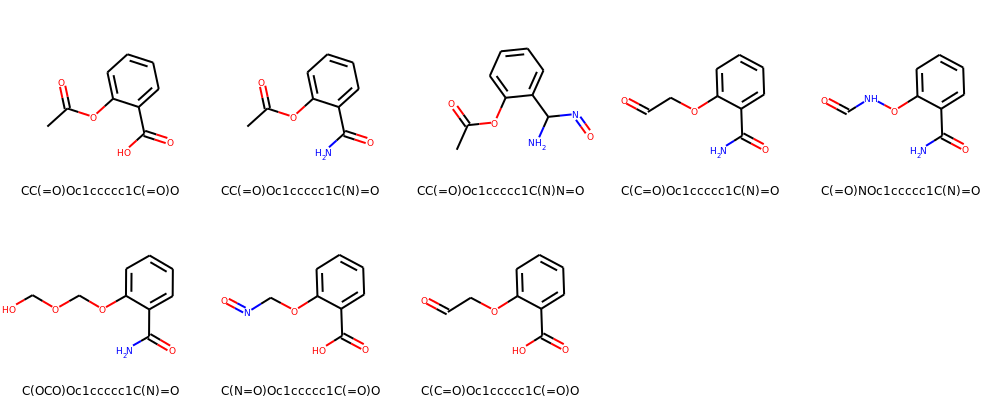

,smiles,distance,count,frequency,mol
0,CC(=O)Oc1ccccc1C(=O)O,0.000005,10,0.104167,"<img src="""" alt=""Mol""/>"
1,CC(=O)Oc1ccccc1C(N)=O,2.793905,72,0.750000,"<img src="""" alt=""Mol""/>"
2,CC(=O)Oc1ccccc1C(N)N=O,4.245938,1,0.010417,"<img src="""" alt=""Mol""/>"
3,C(C=O)Oc1ccccc1C(N)=O,8.322824,5,0.052083,"<img src="""" alt=""Mol""/>"
4,C(=O)NOc1ccccc1C(N)=O,8.607746,5,0.052083,"<img src="""" alt=""Mol""/>"

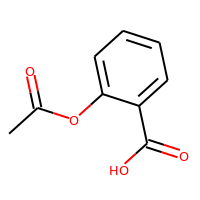
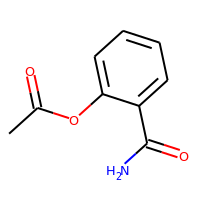
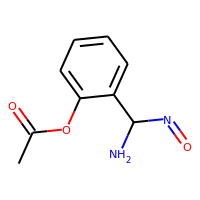
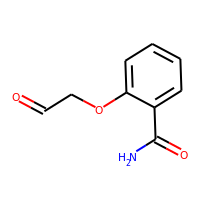
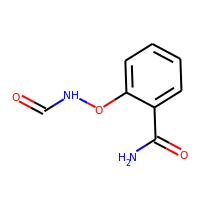

In [13]:
noise=5.0
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles( z_1,decode_attempts=100,noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
df.head()

## PCA of latent space

Sample random points from the training set along with properties

In [14]:
Z, data, smiles = vae.ls_sampler_w_prop(size=50000,return_smiles=True)
prop_opt = 'qed'
prop_df = pd.DataFrame(data).reset_index()
prop_df['smiles']=smiles
prop_df.head()

,index,logP,qed,SAS,smiles
0,172916,2.90510,0.841926,2.091125,C[C@@H](Oc1ccc(C=O)cc1)C(=O)Nc1ccccc1
1,66247,4.37868,0.690634,2.430179,C[C@@H](Nc1ncccc1C#N)c1cccc(NC(=O)c2ccccc2)c1
2,30172,3.98212,0.803056,1.869955,Cc1ccc(C(=O)N(C)Cc2ccc(Cl)s2)cc1
3,22013,2.41630,0.888502,1.976435,CS(=O)(=O)N1CCCc2cc(NC(=O)COc3ccccc3)ccc21
4,67006,3.30100,0.767598,2.436635,O=C(NCC(C1CC1)C1CC1)C(=O)Nc1ccc(-c2nccs2)cc1


Perform a PCA projection and color the points based on a property

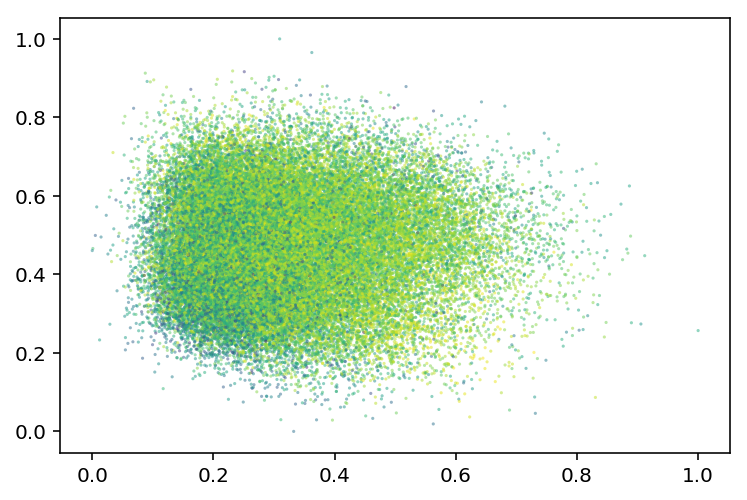

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# do pca and normalize
Z_pca = PCA(n_components=2).fit_transform(Z)
Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()

compare with t-SNE, will take some time

In [ ]:
from sklearn.manifold import TSNE

Z_tsne = TSNE(n_components=2).fit_transform(Z)
Z_tsne = MinMaxScaler().fit_transform(Z_tsne)



In [ ]:
df = pd.DataFrame(np.transpose((Z_tsne[:,0],Z_tsne[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

In [ ]:
plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()